## Analyzing ECCO DATA


This is on the LLC90 grid (1 deg) horizontal resolution

In [1]:
import oceanspy as ospy
import numpy as np
from matplotlib import gridspec
import xarray as xr
from collections import OrderedDict as _OrderedDict
import zarr 
import xmitgcm
from oceanspy.open_oceandataset import _find_entries
from LLC_rearrange import pos_chunks, chunk_sizes, face_connect, arct_connect, Dims

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=12,8

In [3]:
## ORIGINAL, I am making changes to this one (arctic part)
def pos_chunks(faces, arc_faces, chunksY, chunksX):
    '''
    Given the faces in the list nrot_faces (faces in cutout), this code returns the indices of the chunks associated with each face.
    '''
    # Define the baseline to where all faces fall (not counting the arctic)
    nrotA = [k for k in range(3)]
    nrotB = [k for k in range(3,6)]
    nrot = nrotA + nrotB
    rotA = [k for k in range(7,10)] # this ordering is different
    rotB = [k for k in range (10,13)] # this ordering is different
    rot = rotA + rotB
    
    # Now the actual data
    nrot_A = [k for k in faces if k in nrotA]
    nrot_B = [k for k in faces if k in nrotB]
    rot_A = [k for k in faces if k in rotA]
    rot_B = [k for k in faces if k in rotB]

    ny_nApos = len(nrot_A)
    ny_nBpos = len(nrot_B)

    ny_Apos = len(rot_A)
    ny_Bpos = len(rot_B)
    
    POSY = []
    POSX = []
    
    for k in faces:
#         print(k)
        if k in nrot:
            if k in nrot_A:
#                 print('yes')
                xk=0
                yk=0
                if ny_nApos == 1: # just one face
                    yk=0
                elif ny_nApos == 2: # two faces. 
#                     print(['two faces', nrotA])
                    if k == nrot_A[0]: # If first one, then the other one (either 1 or two) has to have position 1
                        yk = 0
#                         print('here')
                    else:
                        yk=1
                elif ny_nApos == 3: # three faces
                    if k == nrotA[0]:
                        yk = 0
                    elif k == nrotA[1]:
                        yk = 1
                    elif k == nrotA[2]:
                        yk = 2
            elif k in nrot_B:
                if ny_nApos > 0: # position to the right of arrays in nrot_A
                    xk = 1
                else:
                    xk = 0
                if ny_nBpos == 1: # just one face
                    yk=0
                elif ny_nBpos == 2: # two faces. 
                    if k == nrot_B[0]: # If first one is zero, then the other one (either 1 or two) has to have position 1
                        yk=0
                    else:
                        yk=1
                elif ny_nBpos == 3: # three faces
                    if k == nrotB[0]:
                        yk = 0
                    elif k == nrotB[1]:
                        yk = 1
                    elif k == nrotB[2]:
                        yk = 2            
        elif k in rot: # Rectangule with largest size in x (when all faces are included)
#             print('face is in rotated faces')
            if k in rot_A: # faces 7-9, 7 closest to Arctic Cap
                xk=0
                yk=0
                if ny_Apos == 1: # just one face
                    xk=0
                elif ny_Apos == 2: # two faces. 
                    if k == rot_A[0]: # If first one is 7, then the other one (either 9 or 10) has to have position 1 in x
                        xk=0
                    else:
                        xk=1
                elif ny_Apos == 3: # three faces
                    if k == rotA[0]:
                        xk = 0
                    elif k == rotA[1]:
                        xk = 1
                    elif k == rotA[2]:
                        xk = 2
            elif k in rot_B: # faces 10-12, 10 closest to Arctic Cap
                if ny_Apos > 0: # position to the right of arrays in rot_A
                    yk = 1
                else:
                    yk = 0
                if ny_Bpos == 1: # just one face
                    xk=0
                elif ny_Bpos == 2: # two faces. 
                    if k == rot_B[0]: # If first one is 10, then the other one (either 1 or two) has to have position 1
                        xk=0
                    else:
                        xk=1
                elif ny_Bpos == 3: # three faces
                    if k == rotB[0]:
                        xk = 0
                    elif k == rotB[1]:
                        xk = 1
                    elif k == rotB[2]:
                        xk = 2
        else:
            print('face index not in LLC grid')
#         print([yk,xk])
        POSY.append(chunksY[yk])
        POSX.append(chunksX[xk])

    # This to create a new list with positions for Arctic cap slices
    POSY_arc = []
    POSX_arc = []
    
    aface_nrot = [k for k in arc_faces if k in nrotA + nrotB] # faces that are on non-rotated facets
    aface_rot = [k for k in arc_faces if k in rotA + rotB] # faces that are in rotated facets

    if len(aface_rot)==0: ## No rotated faces that interact with an arctic slice.
        if len(aface_nrot)==0:  ## No non-rotated faces that interact with arctic slice
            print('no arctic faces')
        else:
            if len(aface_nrot) == 1:  # there is one face that connects with arctic
                POSX_arc.append(chunksX[0])
                POSY_arc.append([chunksY[-1][-1],int(chunksY[-1][-1]+(chunksY[-1][-1]-chunksY[-1][0])/2)])
            elif len(aface_nrot) == 2:  # there are two faces connecting with arctic.
                for k in range(len(aface_nrot)):
                    POSX_arc.append(chunksX[k])
                    POSY_arc.append([chunksY[-1][-1],int(chunksY[-1][-1]+(chunksY[-1][-1]-chunksY[-1][0])/2)])
    else:
         # first element in X for rotated faces (always)
        if len(aface_rot) == 1:  # there is one face that connects with arctic
            POSY_arc.append(chunksY[0])
            POSX_arc.append([0,chunksX[0][0]])
        else:
            for k in range(len(aface_rot)):
                POSX_arc.append([0,chunksX[0][0]])
                POSY_arc.append(chunksY[k])
        
    return POSY, POSX, POSY_arc, POSX_arc

# Non_rot_array[0:Ny_nrot[0],0:Nx_nrot[0]] = od._ds['SST'].isel(face=all_faces[0]) # 
# Non_rot_array[Ny_nrot[0]:,:] = ARCT[0].transpose(transpose_coords=True)

def chunk_sizes(faces, Nx, Ny, rotated=False):
    '''
    Determines the total size of array that will connect into a single face either rotated or non-rotated that survive the cutout
    
    input:
    
        faces: List containing either all rotated or non-rotated faces (indices)
        NX, NY =  Lists with each element the number of poins along an axis within a face (i.e. chunk). For example, LLC4320 grid NX=NY=4320.
                  len(NX)=len(faces)=len(NY)
    '''
    if rotated == False:
        A_ref = np.array([k for k in range(3)]) # this is the reference for the facet A.
        B_ref = np.array([k for k in range(3,6)]) # this is the reference for the facet B.
                # Now the actual data
    elif rotated == True:
        A_ref = np.array([k for k in range(7,10)]) # Reference values for rotated facet A.
        B_ref = np.array([k for k in range(10,13)]) # Reference values for rotated facet B.
    
    A_list = [k for k in faces if k in A_ref]
    B_list = [k for k in faces if k in B_ref]
    
#     Make this work with non-rotated, then figure out the rotation (exchange of Nx to Ny and viceversa)
    if len(A_list)==0: # no faces in facet A
        if len(B_list)>0: # faces in facet B survived the cutout
            tNx = Nx[0] # width in X-axis. For y_axis, we count how many faces there are, to determine how many chunks
            if len(B_list)==1: # Just one face =
                tNy = Ny[0]
            elif len(B_list)==2: # Two faces, but we don't know which
                if min(B_list) == B_ref[0] and max(B_list) == B_ref[-1]: # These two don't connect
                    print('error, these faces do not connect. Not possible to create a single dataset that minimizes nans')
                else:
                    tNy=len(B_list)*Ny[0] # Two faces => two chunks 
            else: # Three faces
                tNy=len(B_list)*Ny[0] # three faces => three chunks in facet
        else: # No faces. 
            tNx=0
            tNy=0
            print('error, no data survives the cutout. Change the values')
    else: # There are faces in facet A
        if len(B_list)==0: # case no faces in facet B.
            tNx = Nx[0] # Width in X is that of one chunk => No connections in X.
            if len(A_list)==1: # just one face => One chunk
                tNy = Ny[0]
            elif len(A_list)==2: # Two faces in y, but which ones of potentially three?
                if min(A_list) == A_ref[0] and max(A_list) == A_ref[-1]: # Faces do not connect 
                    print('error, these faces do not connect. Not possible to create a single datase that minimizes nans') # must raise an error
                    tNy = 0
                else: # there are two faces that do connect
                    tNy = len(A_list)*Ny[0]
            else:  # 3 faces that connect in y survived
                tNy = len(A_list)*Ny[0] # three faces in y
        elif len(B_list)>0: # Two facets. Need to determine the location of faces.
            tNx = 2*Nx[0] # There are 2 chunks in X.
            if len(B_list)==len(A_list):  # For now, only consider this case, to avoid trouble later.
                if len(A_list) == 1:  # Only one face.
                    # need to check that the location of the face facet is the same (i.e. that they connect in X)
                    iA = [np.where(faces[nk] == A_ref)[0][0] for nk in range(len(faces)) if faces[nk] in A_ref]
                    iB = [np.where(faces[nk] == B_ref)[0][0] for nk in range(len(faces)) if faces[nk] in B_ref] 
                    if iA == iB: # Thus must be the same
                        tNy = Ny[0] # There is still only one chunk in Y
                    else:
                        tNy = 0
                        print('Error, faces do not connect within facet')
                elif len(A_list) == 2: # Two faces in facet A (also two faces in facet B)
                    if min(A_list) == A_ref[0] and max(A_list) == A_ref[-1]: # Faces do not connect within facet
                        print('Error, faces do not connect within facet') # raise error
                        tNy = 0
                    else: # Two faces connect within same facet. The location of this faces must be the same as those in B_list
                        iA = [np.where(faces[nk] == A_ref)[0][0] for nk in range(len(faces)) if faces[nk] in A_ref]
                        iB = [np.where(faces[nk] == B_ref)[0][0] for nk in range(len(faces)) if faces[nk] in B_ref] 
                        if iA == iB: # the faces have the same position (elementwise) along their respective facet
                            tNy=len(A_list)*Ny_nrot[0]
                        else:
                            print('error, not all faces connect equally')
                            tNy = 0
                else:  # all 3 faces within facet survived
                    tNy=len(A_list)*Ny[0] # three chunks
            else: # Number of faces in facet A is not the same than in facet B
                tNy = 0
                print('Number of faces in facet A is not equal to the number of faces in facet B.')
    return tNy, tNx

def face_connect(ds, all_faces):
    '''
    Determines the size of the final array consisting of connected faces. Does not consider the Arctic, since the Arctic cap is treated separatedly.
    Input:
        ds : dataset (from OD object)
        all_faces: list of all faces surviving the cutout (this includes the Arctic).
    returns:
        Nx_nrot, Ny_nrot, Nx_rot, Ny_rot
        - Each is a list, containing the number of points of each surviving face, split into rotated and non-rotated faces, since each must be treated differently.
        len(Nx_nrot) = len(Ny_nrot) = number of non-rotated faces.
        len(Nx_rot) = len(Ny_rot) = number of rotated faces involved in the cutout.
    '''
    
    arc_cap = 6 # index of face associated with Arctic Cap. 
    Xdim='X'
    Ydim='Y'

    # Non-rotated faces
    Nx_nrot=[]
    Ny_nrot=[]
    # Rotated faces
    Nx_rot=[]
    Ny_rot=[]
    # Faces that require rotation of axes.
    transpose=np.arange(7,13)
    nrot_faces=[]
    rot_faces=[]

    xpos=0
    ypos=0

    for k in [ii for ii in all_faces if ii not in [arc_cap]]: # iterate through all faces survivin the cutout excluding the arctic cap
        if k in transpose: # faces_index > 6
            x0, xf = 0, int(len(ds[Xdim]))
            y0, yf = 0, int(len(ds[Ydim]))
            Nx_rot.append(len(ds[Xdim][x0:xf]))
            Ny_rot.append(len(ds[Ydim][y0:yf]))
            rot_faces.append(k)
        else: # face_index < 6
            x0, xf = 0, int(len(ds[Xdim]))
            y0, yf = 0, int(len(ds[Ydim]))
            Nx_nrot.append(len(ds[Xdim][x0:xf]))
            Ny_nrot.append(len(ds[Ydim][y0:yf]))
            nrot_faces.append(k)
    return nrot_faces, Nx_nrot, Ny_nrot, rot_faces, Nx_rot, Ny_rot

In [4]:
## NEW ARTIC ONE
def arct_connect(ds, varName, all_faces):  ## change to dataset
    arc_cap = 6
    Nx_ac_nrot = []
    Ny_ac_nrot = []
    Nx_ac_rot  = []
    Ny_ac_rot = []
    ARCT = []
    arc_faces = []
    metrics = ['dxC','dyC','dxG','dyG']

    if arc_cap in all_faces:
        for k in all_faces:
            if k == 2:
                fac = 1
                arc_faces.append(k)
                _varName = varName  ## set only in this
                DIMS = [dim for dim in ds[_varName].dims if dim != 'face']
                dims = Dims(DIMS[::-1])
                dtr = list(dims)[::-1]
                dtr[-1], dtr[-2] = dtr[-2], dtr[-1]
                mask2 = xr.ones_like(ds[_varName].isel(face=arc_cap))
                mask2 = mask2.where(np.logical_and(ds[dims.X] < ds[dims.Y],
                                                   ds[dims.X] < len(ds[dims.Y]) - ds[dims.Y]))
                x0, xf = 0, int(len(ds[dims.Y]) / 2)  ## Consider adding an extra point?
                y0, yf = 0, int(len(ds[dims.X]))
                xslice = slice(x0, xf)
                yslice = slice(y0, yf)
                Nx_ac_nrot.append(0)
                Ny_ac_nrot.append(len(ds[dims.Y][y0:yf]))
                da_arg={'face':arc_cap, dims.X:xslice, dims.Y:yslice}
                sort_arg={'variables':dims.Y, 'ascending':False}
                mask_arg={dims.X:xslice, dims.Y:yslice}
                if len(dims.X) + len(dims.Y) == 4:  ## vector field
                    if len(dims.Y) == 1 and _varName not in metrics:  # V maps to -U
                        fac = - 1
                    if 'mates' in list(ds[_varName].attrs):
                        _varName = ds[_varName].attrs['mates']
                    _DIMS = [dim for dim in ds[_varName].dims if dim != 'face']
                    dims = Dims(_DIMS[::-1]) ## updates the coordinates and mask to consistent coords
                    dtr = list(dims)[::-1]
                    dtr[-1],dtr[-2] = dtr[-2],dtr[-1]
                    mask2 = xr.ones_like(ds[_varName].isel(face=arc_cap))
                    mask2 = mask2.where(np.logical_and(ds[dims.X] < ds[dims.Y],
                                                       ds[dims.X] < len(ds[dims.Y]) - ds[dims.Y]))
                    da_arg = {'face':arc_cap, dims.X:xslice, dims.Y:yslice}
                    sort_arg = {'variables':dims.Y,'ascending':False}
                    mask_arg = {dims.X:xslice, dims.Y:yslice}
                arct = fac * ds[_varName].isel(**da_arg)
                arct = arct.sortby(**sort_arg)
                Mask = mask2.isel(**mask_arg)
                Mask = Mask.sortby(**sort_arg)
                arct = (arct * Mask).transpose(*dtr)
                ARCT.append(arct)

            elif k == 5:
                fac = 1
                arc_faces.append(k)
                _varName = varName
                DIMS = [dim for dim in ds[_varName].dims if dim != 'face']
                dims = Dims(DIMS[::-1])
                mask5 = xr.ones_like(ds[_varName].isel(face=arc_cap))
                mask5 = mask5.where(np.logical_and(ds[dims.X] > ds[dims.Y],
                                                   ds[dims.X] < len(ds[dims.Y]) - ds[dims.Y]))
                x0, xf = 0, int(len(ds[dims.X]))
                y0, yf = 0, int(len(ds[dims.Y]) / 2)  ## potentially add an extra point here towards end, to include arctic pole
                xslice = slice(x0, xf)
                yslice = slice(y0, yf)
                Nx_ac_nrot.append(0)
                Ny_ac_nrot.append(len(ds[dims.X][y0:yf]))
                da_arg={'face':arc_cap, dims.X:xslice, dims.Y:yslice}
                mask_arg={dims.X:xslice, dims.Y:yslice}
                arct = ds[_varName].isel(**da_arg)
                Mask = mask5.isel(**mask_arg)
                arct = (arct * Mask)
                ARCT.append(arct)

            elif k == 7:  ## Transpose axes
                fac = 1
                arc_faces.append(k)
                _varName = varName
                DIMS = [dim for dim in ds[_varName].dims if dim != 'face']
                dims = Dims(DIMS[::-1])
                dtr = list(dims)[::-1]
                dtr[-1], dtr[-2] = dtr[-2], dtr[-1]
                mask7 = xr.ones_like(ds[_varName].isel(face=arc_cap))
                mask7 = mask7.where(np.logical_and(ds[dims.X] > ds[dims.Y],
                                                   ds[dims.X] > len(ds[dims.Y]) - ds[dims.Y]))
                x0, xf = int(len(ds[dims.Y]) / 2), int(len(od._ds[dims.Y]))
                y0, yf = 0, int(len(ds[dims.X]))
                xslice = slice(x0, xf)
                yslice = slice(y0, yf)
                Nx_ac_rot.append(len(ds[dims.Y][x0:xf]))
                Ny_ac_rot.append(0)
                if len(dims.X) + len(dims.Y) == 4:
                    if len(dims.X) == 1 and _varName not in metrics: # U maps to -V
                        fac = - 1
                    if 'mates' in list(ds[varName].attrs):
                        _varName = ds[varName].attrs['mates']
                    DIMS = [dim for dim in ds[_varName].dims if dim != 'face']
                    dims = Dims(DIMS[::-1])
                    dtr = list(dims)[::-1]
                    dtr[-1], dtr[-2] = dtr[-2], dtr[-1]
                    mask7 = xr.ones_like(ds[_varName].isel(face=arc_cap))
                    mask7 = mask7.where(np.logical_and(ds[dims.X] > ds[dims.Y],
                                                       ds[dims.X] > len(ds[dims.Y]) - ds[dims.Y]))
                da_arg = {'face':arc_cap, dims.X:xslice, dims.Y:yslice}
                mask_arg={dims.X:xslice, dims.Y:yslice}
                sort_arg={'variables':[dims.X], 'ascending':False}
                arct = fac * ds[_varName].isel(**da_arg)
                arct = arct.sortby(**sort_arg)
                Mask = mask7.isel(**mask_arg)
                arct = (arct * Mask).transpose(*dtr)
                ARCT.append(arct)

            elif k == 10:
                fac = 1
                _varName = varName
                DIMS = [dim for dim in ds[_varName].dims if dim != 'face']
                dims = Dims(DIMS[::-1])
                arc_faces.append(k)
                mask10 = xr.ones_like(ds[_varName].isel(face=arc_cap))
                mask10 = mask10.where(np.logical_and(ds[dims.X] < ds[dims.Y],
                                                     ds[dims.X] > len(ds[dims.Y]) - ds[dims.Y]))
                x0, xf = 0, int(len(ds[dims.X]))
                y0, yf = int(len(ds[dims.Y]) / 2), int(len(od._ds[dims.Y]))
                xslice = slice(x0, xf)
                yslice = slice(y0, yf)
                Nx_ac_rot.append(0)
                Ny_ac_rot.append(len(ds[dims.Y][y0:yf]))
                if len(dims.X) + len(dims.Y) == 4:
                    if _varName not in metrics:
                        fac = -1
                da_arg = {'face':arc_cap, dims.X:xslice, dims.Y:yslice}
                sort_arg={'variables':[dims.X, dims.Y], 'ascending':False}
                mask_arg={dims.X:xslice, dims.Y:yslice}
                arct = fac * ds[_varName].isel(**da_arg)
                arct = arct.sortby(**sort_arg)
                Mask = mask10.isel(**mask_arg)
                Mask = Mask.sortby(**sort_arg)
                arct = (arct * Mask)
                ARCT.append(arct)
                    
    return arc_faces, Nx_ac_nrot, Ny_ac_nrot, Nx_ac_rot, Ny_ac_rot, ARCT   

# import numpy as np
import reprlib

class Dims:
#     typecode = np.dtype('U1')
    axes = 'XYZT'  # shortcut axis names
    taxes = 'YXZT'  ## axes to transpose

    def __init__(self, vars):
        self._vars = tuple(vars)
        
    def __iter__(self):
        return iter(self._vars)  ## To allow iteration, we return an iterator over self._components
    
    def __repr__(self):
        vars = reprlib.repr(self._vars)
        return '{}'.format(vars)

    def __str__(self):
        return str(tuple(self))
    
    def __eq__(self, other):
        return tuple(self) == tuple(other)
    
    def __len__(self):
        return len(self._vars)

    def __getattr__(self, name):
        cls = type(self)  # Get the Vector class for later use
        if len(name) == 1:  # If the name is one character, it may be one of the shortcut_names.
            pos = cls.axes.find(name)  # Find position of 1-letter name; str.find would also locate 'yz' and we don't want that, this is the reason for the above test
            if 0 <= pos < len(self._vars):  # If position within range, return the array element
                return self._vars[pos]
        msg = '{.__name__!r} object has not attribute {!r}'  # If either test failed, raise AttributeError with a standard message text.
        raise AttributeError(msg.format(cls, name))
        
    def __setattr__(self, name, value):
        cls = type(self)
        if len(name) == 1:  # special handling for single-character attribute names
            if name in cls.axes:  # If name is one of xyzt, set specific error message
                error = 'read-only attribute {attr_name!r}'
            elif name.islower():  # If name is lowercase, set error message about all single-letter names
                error = 'can`t set attributes `a` to `z` in {cls_name!r}'
            else:
                error = ''  # Otherwise, set a black error message
            if error:  # If there is a nonblank error message, raise AttributeError
                msg = error.format(cls_name=cls.__name__, attr_name=name)
                raise AttributeError(msg)
        super().__setattr__(name, value)  # Default case: call __setattr__ on superclass for standard behavior


In [8]:
# ds = xr.open_mfdataset('ECCO_Data/*.nc', parallel=True)
vars_tiled = ['ADVx_SLT','ADVy_SLT','ADVx_TH','ADVy_TH','DFxE_TH', 'DFyE_TH','DFxE_SLT', 'DFyE_SLT', 'DFrI_SLT', 
              'DFrI_TH','ADVr_SLT', 'ADVr_TH', 'oceQnet', 'oceTAUX', 'oceTAUY', 'SALT', 'SFLUX', 'SSH', 'THETA',
              'UVEL', 'VVEL', 'UVELMASS', 'VVELMASS', 'Vm_dPHdy', 'Um_dPHdx']
ds = []
for var in vars_tiled:
    ds1 = xr.open_dataset('ECCO_Data/'+var+'_2017_01.nc')
    ds.append(ds1)
ds = xr.merge(ds).drop(['XC', 'YC'])
ds = ds.drop_dims('nv').reset_coords()
# ds_grid = xr.open_mfdataset('LLC90/nctiles_grid/*.nc', engine='netcdf4', combine='nested', concat_dime='tile').reset_coords()
ds_grid = xr.open_dataset('ECCO_Data/'+'ECCO-GRID.nc').reset_coords()
ds = xr.merge([ds, ds_grid])
ds

<xarray.Dataset>
Dimensions:   (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, tile: 13, time: 1)
Coordinates:
  * i_g       (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * j         (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * tile      (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time      (time) datetime64[ns] 2017-01-16T12:00:00
  * j_g       (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i         (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k_l       (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_p1      (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49 50
  * k_u       (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
Data variables:
    Z         (k) float32 -5.0 -15.0 -25.0 -35.0 ... -5039.25 -5461.25 -5906.25
    timestep  (time) int64 219900
    ADVx_SLT  (time, k, tile, j, i_g) float32 ...
    ADVy_SLT  (time, k, tile, j_g, i) float32 ...
    ADVx_TH   (time, k, tile, j, i_g) float32 ...
    ADVy_TH   (time, k, tile, j_g, i) float32 ...
    DFxE_TH   (time, k, tile, j, i_g) float32 ...
    DFyE_TH   (time, k, tile, j_g, i) float32 ...
    DFxE_SLT  (time, k, tile, j, i_g) float32 ...
    DFyE_SLT  (time, k, tile, j_g, i) float32 ...
    Zl        (k_l) float32 0.0 -10.0 -20.0 -30.0 ... -4834.0 -5244.5 -5678.0
    DFrI_SLT  (time, k_l, tile, j, i) float32 ...
    DFrI_TH   (time, k_l, tile, j, i) float32 ...
    ADVr_SLT  (time, k_l, tile, j, i) float32 ...
    ADVr_TH   (time, k_l, tile, j, i) float32 ...
    oceQnet   (time, tile, j, i) float32 ...
    oceTAUX   (time, tile, j, i_g) float32 ...
    oceTAUY   (time, tile, j_g, i) float32 ...
    SALT      (time, k, tile, j, i) float32 ...
    SFLUX     (time, tile, j, i) float32 ...
    SSH       (time, tile, j, i) float32 ...
    THETA     (time, k, tile, j, i) float32 ...
    UVEL      (time, k, tile, j, i_g) float32 ...
    VVEL      (time, k, tile, j_g, i) float32 ...
    UVELMASS  (time, k, tile, j, i_g) float32 ...
    VVELMASS  (time, k, tile, j_g, i) float32 ...
    Vm_dPHdy  (time, k, tile, j_g, i) float32 ...
    Um_dPHdx  (time, k, tile, j, i_g) float32 ...
    XC        (tile, j, i) float32 ...
    YC        (tile, j, i) float32 ...
    XG        (tile, j_g, i_g) float32 ...
    YG        (tile, j_g, i_g) float32 ...
    CS        (tile, j, i) float32 ...
    SN        (tile, j, i) float32 ...
    Zu        (k_u) float32 ...
    Zp1       (k_p1) float32 ...
    dxC       (tile, j, i_g) float32 ...
    rAs       (tile, j_g, i) float32 ...
    rAw       (tile, j, i_g) float32 ...
    Depth     (tile, j, i) float32 ...
    rA        (tile, j, i) float32 ...
    dxG       (tile, j_g, i) float32 ...
    dyG       (tile, j, i_g) float32 ...
    rAz       (tile, j_g, i_g) float32 ...
    dyC       (tile, j_g, i) float32 ...
    PHrefC    (k) float32 ...
    drC       (k_p1) float32 ...
    PHrefF    (k_p1) float32 ...
    drF       (k) float32 ...
    hFacS     (k, tile, j_g, i) float32 ...
    hFacC     (k, tile, j, i) float32 ...
    hFacW     (k, tile, j, i_g) float32 ...
    maskW     (k, tile, j, i_g) bool ...
    maskC     (k, tile, j, i) bool ...
    maskS     (k, tile, j_g, i) bool ...

In [10]:
od = ospy.OceanDataset(ds)

/Users/Mikejmnez


In [11]:
metadata={}
cat, entries, url, intake_switch = _find_entries('LLC90',None)
entry=entries[-1]
mtdt = cat[entry].metadata
rename = mtdt.pop('rename', None)
od._ds = od._ds.rename(rename)
metadata = {**metadata, **mtdt}
for var in ['aliases', 'parameters', 'name', 'description', 'projection']:
    val = metadata.pop(var, None)
    if val is not None:
        od = eval('od.set_{}(val)'.format(var))
grid_coords = metadata.pop('grid_coords', None)
if grid_coords is not None:
    od = od.set_grid_coords(**grid_coords)
face_connections = metadata.pop('face_connections', None)
if face_connections is not None:
    od = od.set_face_connections(**face_connections)
from xmitgcm.variables import (vertical_coordinates,horizontal_grid_variables,vertical_grid_variables,volume_grid_variables,mask_variables,state_variables,package_state_variables,extra_grid_variables)
variables = _OrderedDict(list(vertical_coordinates.items())+ list(horizontal_grid_variables.items())+ list(vertical_grid_variables.items())+ list(volume_grid_variables.items())+ list(mask_variables.items())+ list(state_variables.items())+ list(package_state_variables.items())+ list(extra_grid_variables.items()))
variables['XC'] = dict(attrs=dict(standard_name=('longitude'),units='degrees_east'))
variables['YC'] = dict(attrs=dict(standard_name=('latitude'),units='degrees_north'))
variables = _OrderedDict(**{var: variables[var] for var in od._ds.variables if var in variables})
for var in variables:
    attrs = variables[var]['attrs']
    for attr in attrs:
        if attr not in od._ds[var].attrs:
            od._ds[var].attrs[attr] = attrs[attr]

In [12]:
od._ds

<xarray.Dataset>
Dimensions:    (X: 90, Xp1: 90, Y: 90, Yp1: 90, Z: 50, Zl: 50, Zp1: 51, face: 13, k_u: 50, time: 1, time_midp: 0)
Coordinates:
  * Xp1        (Xp1) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * Z          (Z) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * Y          (Y) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 2017-01-16T12:00:00
  * Yp1        (Yp1) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * X          (X) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * Zl         (Zl) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * Zp1        (Zp1) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49 50
  * k_u        (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * time_midp  (time_midp) datetime64[ns] 
Data variables:
    Zed        (Z) float32 -5.0 -15.0 -25.0 -35.0 ... -5039.25 -5461.25 -5906.25
    timestep   (time) int64 219900
    ADVx_SLT   (time, Z, face, Y, Xp1) float32 ...
    ADVy_SLT   (time, Z, face, Yp1, X) float32 ...
    ADVx_TH    (time, Z, face, Y, Xp1) float32 ...
    ADVy_TH    (time, Z, face, Yp1, X) float32 ...
    DFxE_TH    (time, Z, face, Y, Xp1) float32 ...
    DFyE_TH    (time, Z, face, Yp1, X) float32 ...
    DFxE_SLT   (time, Z, face, Y, Xp1) float32 ...
    DFyE_SLT   (time, Z, face, Yp1, X) float32 ...
    Zed_l      (Zl) float32 0.0 -10.0 -20.0 -30.0 ... -4834.0 -5244.5 -5678.0
    DFrI_SLT   (time, Zl, face, Y, X) float32 ...
    DFrI_TH    (time, Zl, face, Y, X) float32 ...
    ADVr_SLT   (time, Zl, face, Y, X) float32 ...
    ADVr_TH    (time, Zl, face, Y, X) float32 ...
    oceQnet    (time, face, Y, X) float32 ...
    oceTAUX    (time, face, Y, Xp1) float32 ...
    oceTAUY    (time, face, Yp1, X) float32 ...
    SALT       (time, Z, face, Y, X) float32 ...
    SFLUX      (time, face, Y, X) float32 ...
    SSH        (time, face, Y, X) float32 ...
    THETA      (time, Z, face, Y, X) float32 ...
    UVEL       (time, Z, face, Y, Xp1) float32 ...
    VVEL       (time, Z, face, Yp1, X) float32 ...
    UVELMASS   (time, Z, face, Y, Xp1) float32 ...
    VVELMASS   (time, Z, face, Yp1, X) float32 ...
    Vm_dPHdy   (time, Z, face, Yp1, X) float32 ...
    Um_dPHdx   (time, Z, face, Y, Xp1) float32 ...
    XC         (face, Y, X) float32 ...
    YC         (face, Y, X) float32 ...
    XG         (face, Yp1, Xp1) float32 ...
    YG         (face, Yp1, Xp1) float32 ...
    CS         (face, Y, X) float32 ...
    SN         (face, Y, X) float32 ...
    Zu         (k_u) float32 -10.0 -20.0 -30.0 -40.0 ... -5244.5 -5678.0 -6134.5
    Zed_p1     (Zp1) float32 0.0 -10.0 -20.0 -30.0 ... -5244.5 -5678.0 -6134.5
    dxC        (face, Y, Xp1) float32 ...
    rAs        (face, Yp1, X) float32 ...
    rAw        (face, Y, Xp1) float32 ...
    Depth      (face, Y, X) float32 ...
    rA         (face, Y, X) float32 ...
    dxG        (face, Yp1, X) float32 ...
    dyG        (face, Y, Xp1) float32 ...
    rAz        (face, Yp1, Xp1) float32 ...
    dyC        (face, Yp1, X) float32 ...
    PHrefC     (Z) float32 49.05 147.15 245.25 ... 49435.043 53574.863 57940.312
    drC        (Zp1) float32 5.0 10.0 10.0 10.0 ... 399.0 422.0 445.0 228.25
    PHrefF     (Zp1) float32 0.0 98.1 196.2 ... 51448.547 55701.18 60179.445
    drF        (Z) float32 10.0 10.0 10.0 10.0 10.0 ... 387.5 410.5 433.5 456.5
    hFacS      (Z, face, Yp1, X) float32 ...
    hFacC      (Z, face, Y, X) float32 ...
    hFacW      (Z, face, Y, Xp1) float32 ...
    maskW      (Z, face, Y, Xp1) bool ...
    maskC      (Z, face, Y, X) bool ...
    maskS      (Z, face, Yp1, X) bool ...
Attributes:
    OceanSpy_parameters:        {'rSphere': 6371.0, 'eq_state': 'jmd95', 'rho...
    OceanSpy_name:              LLC4320
    OceanSpy_description:       LLC90 ECCO data from the MITGCM, a general, c...
    OceanSpy_grid_coords:       

## Mates (Vector Pairs) on attributes


In [6]:
vars_mates = ['ADVx_SLT','ADVy_SLT','ADVx_TH','ADVy_TH','DFxE_TH', 'DFyE_TH','DFxE_SLT', 'DFyE_SLT', 'maskW', 'maskS',
              'TAUX', 'TAUY', 'U', 'V', 'UVELMASS', 'VVELMASS', 'dxC', 'dyC', 'dxG', 'dyG', 'hFacW','hFacS', 'rAw', 'rAs']  #
for k in range(int(len(vars_mates) / 2)):
    nk = 2 * k
    print([vars_mates[nk],vars_mates[nk + 1]])
    od._ds[vars_mates[nk]].attrs['mates'] = vars_mates[nk + 1]
    od._ds[vars_mates[nk+1]].attrs['mates'] = vars_mates[nk]

['ADVx_SLT', 'ADVy_SLT']
['ADVx_TH', 'ADVy_TH']
['DFxE_TH', 'DFyE_TH']
['DFxE_SLT', 'DFyE_SLT']
['maskW', 'maskS']
['TAUX', 'TAUY']
['U', 'V']
['UVELMASS', 'VVELMASS']
['dxC', 'dyC']
['dxG', 'dyG']
['hFacW', 'hFacS']
['rAw', 'rAs']


In [7]:
ds = od._ds
ds

<xarray.Dataset>
Dimensions:    (X: 90, Xp1: 90, Y: 90, Yp1: 90, Z: 50, Z_l: 50, Z_p1: 51, face: 13, time: 1, time_midp: 0)
Coordinates:
  * Z          (Z) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * Xp1        (Xp1) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * Y          (Y) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * time       (time) datetime64[ns] 2017-01-16T12:00:00
  * Yp1        (Yp1) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * X          (X) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * Z_l        (Z_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * time_midp  (time_midp) datetime64[ns] 
Dimensions without coordinates: Z_p1
Data variables:
    Zed        (Z) float32 -5.0 -15.0 -25.0 -35.0 ... -5039.25 -5461.25 -5906.25
    timestep   (time) int64 219900
    ADVx_SLT   (time, Z, face, Y, Xp1) float32 ...
    ADVy_SLT   (time, Z, face, Yp1, X) float32 ...
    ADVx_TH    (time, Z, face, Y, Xp1) float32 ...
    ADVy_TH    (time, Z, face, Yp1, X) float32 ...
    DFxE_TH    (time, Z, face, Y, Xp1) float32 ...
    DFyE_TH    (time, Z, face, Yp1, X) float32 ...
    DFxE_SLT   (time, Z, face, Y, Xp1) float32 ...
    DFyE_SLT   (time, Z, face, Yp1, X) float32 ...
    Zed_l      (Z_l) float32 0.0 -10.0 -20.0 -30.0 ... -4834.0 -5244.5 -5678.0
    DFrI_SLT   (time, Z_l, face, Y, X) float32 ...
    DFrI_TH    (time, Z_l, face, Y, X) float32 ...
    ADVr_SLT   (time, Z_l, face, Y, X) float32 ...
    ADVr_TH    (time, Z_l, face, Y, X) float32 ...
    Qnet       (time, face, Y, X) float32 ...
    TAUX       (time, face, Y, Xp1) float32 ...
    TAUY       (time, face, Yp1, X) float32 ...
    S          (time, Z, face, Y, X) float32 ...
    SFLUX      (time, face, Y, X) float32 ...
    ETA        (time, face, Y, X) float32 ...
    T          (time, Z, face, Y, X) float32 ...
    U          (time, Z, face, Y, Xp1) float32 ...
    V          (time, Z, face, Yp1, X) float32 ...
    UVELMASS   (time, Z, face, Y, Xp1) float32 ...
    VVELMASS   (time, Z, face, Yp1, X) float32 ...
    Vm_dPHdy   (time, Z, face, Yp1, X) float32 ...
    Um_dPHdx   (time, Z, face, Y, Xp1) float32 ...
    Depth      (face, Y, X) float32 dask.array<chunksize=(7, 90, 90), meta=np.ndarray>
    XC         (face, Y, X) float32 dask.array<chunksize=(7, 90, 90), meta=np.ndarray>
    XG         (face, Yp1, Xp1) float32 dask.array<chunksize=(7, 90, 90), meta=np.ndarray>
    YC         (face, Y, X) float32 dask.array<chunksize=(7, 90, 90), meta=np.ndarray>
    YG         (face, Yp1, Xp1) float32 dask.array<chunksize=(7, 90, 90), meta=np.ndarray>
    Zed_p1     (Z_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    drF        (Z) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    dxC        (face, Y, Xp1) float32 dask.array<chunksize=(7, 90, 90), meta=np.ndarray>
    dxG        (face, Yp1, X) float32 dask.array<chunksize=(7, 90, 90), meta=np.ndarray>
    dyC        (face, Yp1, X) float32 dask.array<chunksize=(7, 90, 90), meta=np.ndarray>
    dyG        (face, Y, Xp1) float32 dask.array<chunksize=(7, 90, 90), meta=np.ndarray>
    hFacC      (face, Z, Y, X) float32 dask.array<chunksize=(4, 25, 45, 45), meta=np.ndarray>
    hFacS      (face, Z, Yp1, X) float32 dask.array<chunksize=(4, 25, 45, 45), meta=np.ndarray>
    hFacW      (face, Z, Y, Xp1) float32 dask.array<chunksize=(4, 25, 45, 45), meta=np.ndarray>
    maskC      (face, Z, Y, X) int8 dask.array<chunksize=(7, 25, 45, 45), meta=np.ndarray>
    maskS      (face, Z, Yp1, X) int8 dask.array<chunksize=(7, 25, 45, 45), meta=np.ndarray>
    maskW      (face, Z, Y, Xp1) int8 dask.array<chunksize=(7, 25, 45, 45), meta=np.ndarray>
    rA         (face, Y, X) float32 dask.array<chunksize=(7, 90, 90), meta=np.ndarray>
    rAs        (face, Yp1, X) float32 dask.array<chunksize=(7, 90, 90), meta=np.ndarray>
    rAw        (face, Y, Xp1) float32 dask.

# Cutout from Faces Known

In order to determine the final size of the array, you need to supply a variable, the size of the chunks (size of faces) and a list of faces.


In [8]:
varName = 'Depth' # A 2D variable for simplicity
Nx = len(od._ds['X'])
Ny = len(od._ds['Y'])
all_faces = [k for k in range(13)] # except arc_cap. Get this list from cutout procedure (1st)
# all_faces = [2,6,10]
print(all_faces)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [9]:
nrot_faces, Nx_nrot, Ny_nrot, rot_faces, Nx_rot, Ny_rot = face_connect(ds, all_faces)
arc_faces, Nx_ac_nrot, Ny_ac_nrot, Nx_ac_rot, Ny_ac_rot, ARCT = arct_connect(ds, varName, all_faces)

In [10]:
## Define order sequence of faces which exchange data with the Arctic
acnrot_faces = [k for k in arc_faces if k in np.array([2,5])]
acrot_faces = [k for k in arc_faces if k in np.array([7,10])]

print(['Faces that survive the cutout and exchange data with arctic ', 'non-rot faces', acnrot_faces, 'rot-faces ', acrot_faces])

['Faces that survive the cutout and exchange data with arctic ', 'non-rot faces', [2, 5], 'rot-faces ', [7, 10]]


In [11]:
nrot_A = [k for k in nrot_faces if k in np.arange(3)]  # non-rotated Facet A
nrot_B = [k for k in nrot_faces if k in np.arange(3,6)]  # non-rotated Facet B
rot_A = [k for k in rot_faces if k in np.arange(7,10)]  # rotated Facet A
rot_B = [k for k in rot_faces if k in np.arange(10,13)]  # rotated Facet B

['facets[face]', nrot_A, nrot_B, rot_A, rot_B]

['facets[face]', [0, 1, 2], [3, 4, 5], [7, 8, 9], [10, 11, 12]]

In [12]:
# This is the final shape of the Non-Rotated merged facets
tNy_nrot, tNx_nrot = chunk_sizes(nrot_faces, [Nx], [Nx]) # Nx, Ny is the chunksize
(tNy_nrot, tNx_nrot)

(270, 180)

In [13]:
# Now, the final shape of the Rotated-merged facets
tNx_rot, tNy_rot = chunk_sizes(rot_faces, [Nx], [Ny], rotated=True)
(tNy_rot, tNx_rot)

(180, 270)

## Include the Arctic Cap (triangular region)
Only true, if Arctic suvives the cutout. If it doesn't, then nothing happends


In [14]:
# Including the Arctic Cap. 
# zero unless the arctic is to be included
delNX = 0
delNY = 0
if len(ARCT)>0:
    delNX = int(Nx/2) #for rotated
    delNY = int(Ny/2) # for nonrotated
tNy_nrot = tNy_nrot + delNY # On non-rotated faces, the including the arctic
tNx_rot = tNx_rot + delNX

print(['faces',nrot_faces,'Non-Rotated (Ny,Nx):',(tNy_nrot, tNx_nrot)])
print(['faces',rot_faces,'Rotated (Ny,Nx)',tNy_rot, tNx_rot])

['faces', [0, 1, 2, 3, 4, 5], 'Non-Rotated (Ny,Nx):', (315, 180)]
['faces', [7, 8, 9, 10, 11, 12], 'Rotated (Ny,Nx)', 180, 315]


## Combine faces

Create naned-array (sparse matrix?) with the sizes calculated above. The next step, is to figure out the indices associated with the chunks (faces) we need to populate.

In [15]:
# In the non-rotated faces, including the arct cap does nothing to the indices of the non-arct chunks
Nx_nrot = np.arange(0,tNx_nrot+1,Nx)
Ny_nrot = np.arange(0,tNy_nrot+1,Ny)
Ny_nrot, Nx_nrot

(array([  0,  90, 180, 270]), array([  0,  90, 180]))

In [16]:
chunksX_nrot = []
chunksY_nrot = []
for ii in range(len(Nx_nrot)-1):
    chunksX_nrot.append([Nx_nrot[ii],Nx_nrot[ii+1]])
for jj in range(len(Ny_nrot)-1):
    chunksY_nrot.append([Ny_nrot[jj],Ny_nrot[jj+1]])
'chunk in Y',chunksY_nrot, 'chunk in X', chunksX_nrot

('chunk in Y',
 [[0, 90], [90, 180], [180, 270]],
 'chunk in X',
 [[0, 90], [90, 180]])

In [17]:
POSY_nrot, POSX_nrot, POSYarc_nrot, POSXarc_nrot = pos_chunks(nrot_faces, acnrot_faces,chunksY_nrot, chunksX_nrot)
'position in Y', POSY_nrot, 'position in X', POSX_nrot

('position in Y',
 [[0, 90], [90, 180], [180, 270], [0, 90], [90, 180], [180, 270]],
 'position in X',
 [[0, 90], [0, 90], [0, 90], [90, 180], [90, 180], [90, 180]])

In [18]:
'position in Y',POSYarc_nrot, 'position in X', POSXarc_nrot

('position in Y',
 [[270, 315], [270, 315]],
 'position in X',
 [[0, 90], [90, 180]])

### ROTATED 

In [19]:
## Inclusion of the Arctic does affect the location/position of the chunks so it needs to be included
Nx_rot = np.arange(delNX,tNx_rot+1,Nx)
Ny_rot = np.arange(0,tNy_rot+1,Ny)
Nx_rot, Ny_rot

(array([ 45, 135, 225, 315]), array([  0,  90, 180]))

In [20]:
chunksX_rot=[]
chunksY_rot=[]
for ii in range(len(Nx_rot)-1):
    chunksX_rot.append([Nx_rot[ii],Nx_rot[ii+1]])
for jj in range(len(Ny_rot)-1):
    chunksY_rot.append([Ny_rot[jj],Ny_rot[jj+1]])
'chunk in Y',chunksY_rot, 'chunk in X', chunksX_rot

('chunk in Y',
 [[0, 90], [90, 180]],
 'chunk in X',
 [[45, 135], [135, 225], [225, 315]])

In [21]:
POSY_rot, POSX_rot, POSYa_rot, POSXa_rot = pos_chunks(rot_faces, acrot_faces, chunksY_rot, chunksX_rot)

In [22]:
print(['pos in Y',POSY_rot,'pos in X', POSX_rot])

['pos in Y', [[0, 90], [0, 90], [0, 90], [90, 180], [90, 180], [90, 180]], 'pos in X', [[45, 135], [135, 225], [225, 315], [45, 135], [135, 225], [225, 315]]]


In [23]:
print(['pos triangle in Y ', POSYa_rot,'pos triangle in X ', POSXa_rot])

['pos triangle in Y ', [[0, 90], [90, 180]], 'pos triangle in X ', [[0, 45]]]


### Create Arrays compatibles in dimension

In [24]:
## This only applicable if the faces [2, 5, 7 and 10] are involved. Its the choice to center the map on either Atlantic or Pacific Ocean 

centered_ON = 'Atlantic'
# centered_ON = 'Pacific'
X0=0
Xr0=0
if centered_ON == 'Atlantic':
    X0=tNy_rot
    
elif centered_ON == 'Pacific':
    Xr0 = tNx_nrot

print(['(X0,Xr0)',X0, Xr0])


['(X0,Xr0)', 180, 0]


In [25]:
## NON-rotated dataset (facets)
## Work with DS directly, not with OD
##### TODO!!!: Crete variables here (initialized them as empty). Easier than what I am doing after, and thus avoiding creating very large np.arrays (zeros) of Order of Tbytes)


coords_nrot={'X':(('X',), np.arange(X0,X0+tNx_nrot),{'axis': 'X'}),
             'Xp1':(('Xp1',), np.arange(X0,X0+tNx_nrot),{'axis':'X'}),
             'Y':(('Y',), np.arange(tNy_nrot),{'axis': 'Y'}),
             'Yp1':(('Yp1',), np.arange(tNy_nrot), {'axis':'Y'}),
             'Z': (('Z',), np.arange(len(ds['Z'])), {'axis': 'Z'}),
             'Z_p1':(('Z_p1',), np.arange(len(ds['Z_p1'])), {'axis':'Z'}),
             'Z_l': (('Z_l',), np.arange(len(ds['Z_l'])), {'axis':'Z'}),
             'time': (('time',), ds['time'].data, {'axis':'T'}),   
                             }
hcoords_nrot={'X':coords_nrot['X'],
              'Xp1':coords_nrot['Xp1'],
              'Y':coords_nrot['Y'],
              'Yp1':coords_nrot['Yp1']}

NR_dsnew = xr.Dataset(coords=coords_nrot)
for dim in NR_dsnew.dims:
    NR_dsnew[dim].attrs = ds[dim].attrs

In [26]:
# ### Rotated dataset (facets)
coords_rot={'X':(('X',), np.arange(Xr0, Xr0 + tNy_rot),{'axis': 'X'}),
            'Xp1':(('Xp1',), np.arange(Xr0, Xr0 + tNy_rot), {'axis':'X'}),
            'Y':(('Y',), np.arange(tNx_rot),{'axis': 'Y'}),
            'Yp1':(('Yp1',), np.arange(tNx_rot),{'axis':'Y'}),
            'Z': (('Z',), np.arange(len(ds['Z'])), {'axis': 'Z'}),
            'Z_p1':(('Z_p1',), np.arange(len(ds['Z_p1'])), {'axis':'Z'}), 
            'Z_l': (('Z_l',), np.arange(len(ds['Z_l'])), {'axis':'Z'}),
            'time': (('time',), ds['time'].data, {'axis':'T'}),                
                             }
# hcoords_rot={'X':coords_rot['X'],
#              'Xp1':coords_rot['Xp1'],
#              'Y':coords_rot['Y'],
#              'Yp1':coords_rot['Yp1']}
R_dsnew = xr.Dataset(coords=coords_rot)
for dim in R_dsnew.dims:
    R_dsnew[dim].attrs = ds[dim].attrs

## Define list of variables to include in the cutout


In [27]:
varlist = ['T','Depth', 'U', 'V', 'UVELMASS','VVELMASS','TAUX','TAUY','ADVx_SLT','ADVy_SLT','ADVx_TH','ADVy_TH','DFxE_TH','DFyE_TH', 'DFxE_SLT','DFyE_SLT','XC', 'YC', 'XG', 'YG', 'dxC', 'dyC', 'dxG', 'dyG'] #
# varlist = ['T','U','V','Depth','XC', 'YC', 'XG', 'YG'] #
metrics = ['dxC', 'dyC', 'dxG', 'dyG']
# for varName in varlist:
for varName in ds.data_vars:
    vName = varName
    print(varName)
    fac = 1
    dims = Dims([dim for dim in ds[varName].dims if dim != 'face'][::-1])
    if len(ds[varName].dims) == 1:
        R_dsnew[varName] =(dims._vars[::-1], ds[varName].data)
        NR_dsnew[varName] = (dims._vars[::-1],ds[varName].data)
        NR_dsnew[varName].attrs = od._ds[varName].attrs
        R_dsnew[varName].attrs = od._ds[varName].attrs
    else: 
        _shape = tuple([len(NR_dsnew[var]) for var in tuple(dims)[::-1]])
        NR_dsnew[varName] = (dims._vars[::-1], np.nan * np.zeros(_shape))
        R_dsnew[varName] = (dims._vars[::-1], np.nan * np.zeros(_shape))
        NR_dsnew[varName].attrs = od._ds[varName].attrs
        R_dsnew[varName].attrs = od._ds[varName].attrs
        if len(dims.X) + len(dims.Y) == 4:  # vector fields
            if 'mates' in list(ds[varName].attrs):
                vName = ds[varName].attrs['mates']
            if len(dims.X) == 1 and varName not in metrics: ## all variables except dxG, dyC, dyG
                fac = -1
        arc_faces, Nx_ac_nrot, Ny_ac_nrot, Nx_ac_rot, Ny_ac_rot, ARCT = arct_connect(ds, varName, all_faces) ## If feed U for face 
        for k in range(len(nrot_faces)):
            data = od._ds[varName].isel(face=nrot_faces[k]).values
            xslice = slice(POSX_nrot[k][0], POSX_nrot[k][1])
            yslice = slice(POSY_nrot[k][0], POSY_nrot[k][1])
            arg={dims.X:xslice, dims.Y:yslice}
            NR_dsnew[varName].isel(**arg)[:] = data
        for k in range(len(rot_faces)):
            kk = len(rot_faces)-(k+1)
            xslice = slice(POSX_nrot[k][0], POSX_nrot[k][1])
            yslice = slice(POSY_nrot[kk][0], POSY_nrot[kk][1])
            data = fac * od._ds[vName].isel(face=rot_faces[k])  ## initially U samples V
            arg={dims.Y:yslice, dims.X:xslice} # dims of original
            dtr=list(dims)[::-1]
            dtr[-1], dtr[-2] = dtr[-2], dtr[-1]
            ndims = Dims(list(data.dims)[::-1])
            sort_arg={'variables':ndims.X, 'ascending':False}
            data = data.sortby(**sort_arg)
            R_dsnew[varName].isel(**arg).transpose(*dtr)[:] = data.values # save into U
        for k in range(len(acnrot_faces)):  ###
            data=ARCT[k]
            xslice = slice(POSXarc_nrot[k][0], POSXarc_nrot[k][1])
            yslice = slice(POSYarc_nrot[k][0], POSYarc_nrot[k][1])
            data =  ARCT[k]
            arg={dims.X:xslice, dims.Y:yslice}
            NR_dsnew[varName].isel(**arg)[:] = data.values
        for k in range(len(acrot_faces)):
            tk = len(acnrot_faces) + k
            xslc = slice(POSXarc_nrot[k][0], POSXarc_nrot[k][1])
            yslc = slice(POSYarc_nrot[k][0], POSYarc_nrot[k][1])
            arg={dims.Y:yslc, dims.X:xslc}
            data = ARCT[tk] #
            R_dsnew[varName].isel(**arg)[:] = data.values

Zed
timestep
ADVx_SLT
ADVy_SLT
ADVx_TH
ADVy_TH
DFxE_TH
DFyE_TH
DFxE_SLT
DFyE_SLT
Zed_l
DFrI_SLT
DFrI_TH
ADVr_SLT
ADVr_TH
Qnet
TAUX
TAUY
S
SFLUX
ETA
T
U
V
UVELMASS
VVELMASS
Vm_dPHdy
Um_dPHdx
Depth
XC
XG
YC
YG
Zed_p1
drF
dxC
dxG
dyC
dyG
hFacC
hFacS
hFacW
maskC
maskS
maskW
rA
rAs
rAw
rAz


## Combine both datasets
Consider chunking here? Check performance

In [28]:
if centered_ON == 'Atlantic':
    DS=R_dsnew.combine_first(NR_dsnew)
# elif centered_ON == 'Pacific':
    DS=NR_dsnew.combine_first(R_dsnew)
DS=DS.reset_coords()

In [30]:
NXG=len(DS['Xp1'])
NYG=len(DS['Yp1'])
DS_final = xr.Dataset(coords={'X':(('X',), np.arange(NXG-1),{'axis': 'X'}),
                             'Xp1':(('Xp1',), np.arange(NXG),{'axis':'X'}),
                             'Y':(('Y',), np.arange(NYG-1),{'axis': 'Y'}),
                             'Yp1':(('Yp1',), np.arange(NYG), {'axis':'Y'}),
                              'Z': (('Z',), np.arange(len(ds['Z'])), {'axis': 'Z'}),
                              'Z_p1':(('Z_p1',), np.arange(len(ds['Z_p1'])), {'axis':'Z'}), 
                              'Z_l': (('Z_l',), np.arange(len(ds['Z_l'])), {'axis':'Z'}),
                              'time': (('time',), ds['time'].data, {'axis':'T'}),                
                             }
                     )
for dim in DS_final.dims:
    DS_final[dim].attrs = ds[dim].attrs
for varName in DS.data_vars:
    dims = Dims([dim for dim in DS[varName].dims][::-1])
    if len(dims)==1:
        DS_final[varName] = DS[varName]
    else:
        if len(dims.X) + len(dims.Y) == 2:
            arg = {dims.X: slice(0,-1), dims.Y: slice(0,-1)}
        elif len(dims.X)+len(dims.Y)==6:
            arg={}
        elif len(dims.X)+len(dims.Y)==4:
            if len(dims.X) == 1: # v-points
                arg = {dims.X:slice(0,-1)}
            elif len(dims.Y) == 1: # u-points
                arg = {dims.Y: slice(0,-1)}
        DS_final[varName] = DS[varName].isel(**arg)
    DS_final[varName].attrs = DS[varName].attrs

In [31]:
DS_final

<xarray.Dataset>
Dimensions:   (X: 359, Xp1: 360, Y: 314, Yp1: 315, Z: 50, Z_l: 50, Z_p1: 51, time: 1)
Coordinates:
  * X         (X) int64 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358
  * Xp1       (Xp1) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * Y         (Y) int64 0 1 2 3 4 5 6 7 8 ... 306 307 308 309 310 311 312 313
  * Yp1       (Yp1) int64 0 1 2 3 4 5 6 7 8 ... 307 308 309 310 311 312 313 314
  * Z         (Z) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * Z_p1      (Z_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49 50
  * Z_l       (Z_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * time      (time) datetime64[ns] 2017-01-16T12:00:00
Data variables:
    Zed       (Z) float32 -5.0 -15.0 -25.0 -35.0 ... -5039.25 -5461.25 -5906.25
    timestep  (time) int64 219900
    ADVx_SLT  (time, Z, Y, Xp1) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    ADVy_SLT  (time, Z, Yp1, X) float64 -0.0 -0.0 -0.0 -0.0 ... nan nan nan nan
    ADVx_TH   (time, Z, Y, Xp1) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    ADVy_TH   (time, Z, Yp1, X) float64 -0.0 -0.0 -0.0 -0.0 ... nan nan nan nan
    DFxE_TH   (time, Z, Y, Xp1) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    DFyE_TH   (time, Z, Yp1, X) float64 -0.0 -0.0 -0.0 -0.0 ... nan nan nan nan
    DFxE_SLT  (time, Z, Y, Xp1) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    DFyE_SLT  (time, Z, Yp1, X) float64 -0.0 -0.0 -0.0 -0.0 ... nan nan nan nan
    Zed_l     (Z_l) float32 0.0 -10.0 -20.0 -30.0 ... -4834.0 -5244.5 -5678.0
    DFrI_SLT  (time, Z_l, Y, X) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    DFrI_TH   (time, Z_l, Y, X) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    ADVr_SLT  (time, Z_l, Y, X) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    ADVr_TH   (time, Z_l, Y, X) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    Qnet      (time, Y, X) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    TAUX      (time, Y, Xp1) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    TAUY      (time, Yp1, X) float64 -0.0 -0.0 -0.0 -0.0 ... nan nan nan nan
    S         (time, Z, Y, X) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    SFLUX     (time, Y, X) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    ETA       (time, Y, X) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    T         (time, Z, Y, X) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    U         (time, Z, Y, Xp1) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    V         (time, Z, Yp1, X) float64 -0.0 -0.0 -0.0 -0.0 ... nan nan nan nan
    UVELMASS  (time, Z, Y, Xp1) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    VVELMASS  (time, Z, Yp1, X) float64 -0.0 -0.0 -0.0 -0.0 ... nan nan nan nan
    Vm_dPHdy  (time, Z, Yp1, X) float64 -0.0 -0.0 -0.0 -0.0 ... nan nan nan nan
    Um_dPHdx  (time, Z, Y, Xp1) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    Depth     (Y, X) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan nan
    XC        (Y, X) float64 68.39 68.7 69.06 69.49 70.03 ... nan nan nan nan
    XG        (Yp1, Xp1) float64 71.53 72.08 72.74 73.52 ... nan nan nan nan
    YC        (Y, X) float64 -88.24 -88.38 -88.52 -88.66 ... nan nan nan nan
    YG        (Yp1, Xp1) float64 -88.16 -88.3 -88.44 -88.58 ... nan nan nan nan
    Zed_p1    (Z_p1) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    drF       (Z) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    dxC       (Y, Xp1) float64 1.558e+04 1.559e+04 1.559e+04 ... nan nan nan
    dxG       (Yp1, X) float64 1.559e+04 1.559e+04 1.56e+04 ... nan nan nan
    dyC       (Yp1, X) float64 2.347e+04 2.353e+04 2.359e+04 ... nan nan nan
    dyG       (Y, Xp1) float64 2.321e+04 2.327e+04 2.333e+04 ... nan nan nan
    hFacC     (Z, Y, X) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    hFacS     (Z, Yp1, X) float64 -0.0 -0.0 -0.0 -0.0 -0.0 ... nan nan nan nan
    hFacW     (Z, Y, Xp1) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan n

## Make OSPY

In [32]:
cut_od = ospy.OceanDataset(DS_final)
metadata = {}
cat, entries, url, intake_switch = _find_entries('LLC90', None)
entry = entries[-1]
mtdt = cat[entry].metadata
metadata = {**metadata, **mtdt}
grid_coords = metadata.pop('grid_coords', None)
del grid_coords['grid_coords']['time']
del grid_coords['add_midp']
# metadata['grid_periodic']={'periodic':'X'}
metadata['manipulate_coords']={'coordsUVfromG':True}
manipulate_coords = metadata.pop('manipulate_coords', None)
cut_od = cut_od.manipulate_coords(**manipulate_coords)
cut_od = cut_od.set_grid_coords(**grid_coords, overwrite=True)

/Users/Mikejmnez/anaconda3/envs/Oceanography/lib/python3.7/site-packages/xarray/core/dataarray.py:1965: FutureWarning: dropping coordinates using `drop` is be deprecated; use drop_vars.
  ds = self._to_temp_dataset().drop(labels, dim, errors=errors)


In [33]:
grid = cut_od.grid
# hFacG = grid.interp(cut_od._ds['hFacW'], axis='Y', boundary='extrapolate')
DepthG=grid.interp(grid.interp(cut_od._ds['Depth'], axis='X', boundary='extrapolate'), axis='Y', boundary='extrapolate')
DepthU=grid.interp(cut_od._ds['Depth'], axis='X', boundary='extrapolate')
DepthV=grid.interp(cut_od._ds['Depth'], axis='Y', boundary='extrapolate')
# cut_od._ds['hFacG'] = hFacG
cut_od._ds['DepthG'] = DepthG
cut_od._ds['DepthU'] = DepthU
cut_od._ds['DepthV'] = DepthV

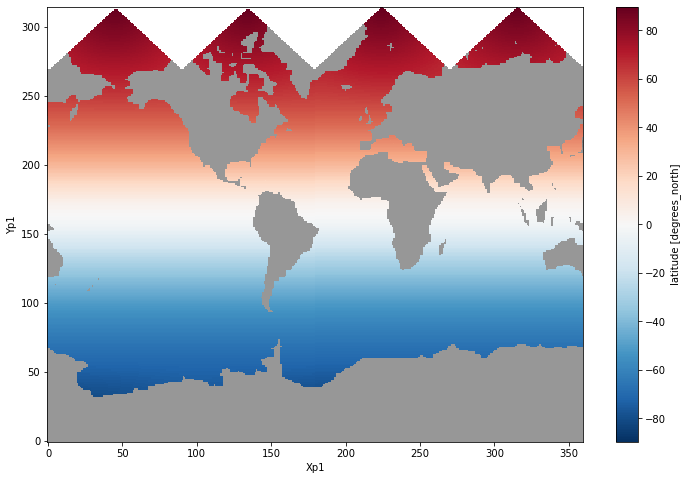

In [34]:
cut_od._ds['DepthG'].plot(cmap='Greys_r', add_colorbar=False)
((cut_od._ds['YG']).where(cut_od._ds['DepthG']>0)).plot(cmap='RdBu_r')
# plt.savefig('Figures/LLC90_SSU_snapshot_allfaces.png')
plt.show()

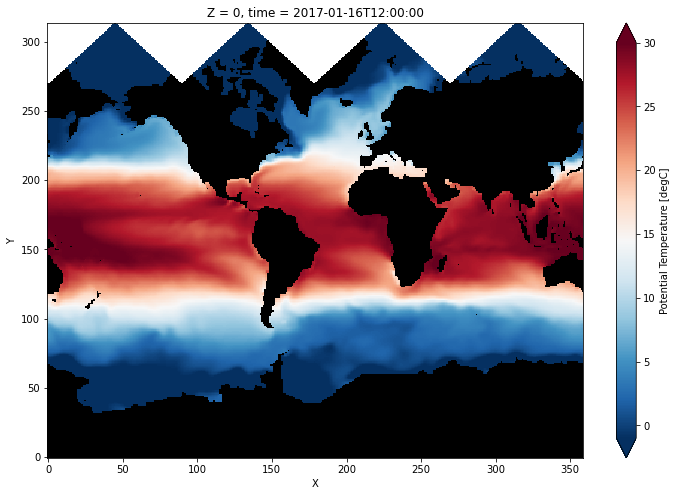

In [38]:
_varName='T'
_depth='Depth'
cut_od._ds[_depth].plot(cmap='Greys_r', add_colorbar=False)
# ((cut_od._ds[_varName].isel(Z=0,time=0)).where(cut_od._ds[_depth] > 0)).plot(cmap='seismic')   #     
((cut_od._ds[_varName].isel(time=0,Z=0)).where(cut_od._ds[_depth] > 0)).plot(cmap='RdBu_r', vmin=-1, vmax=30) 
plt.savefig('Figures/LLC90_'+_varName+'_snapshot_allfaces.png')
plt.show()

## Relative Vorticity

In [39]:
cut_od = cut_od.compute.curl(iName='U', jName='V')

Computing curl.


/Users/Mikejmnez/anaconda3/envs/Oceanography/lib/python3.7/site-packages/oceanspy/_oceandataset.py:832: FutureWarning: dropping coordinates using `drop` is be deprecated; use drop_vars.
  obj = obj.drop(obj.coords)


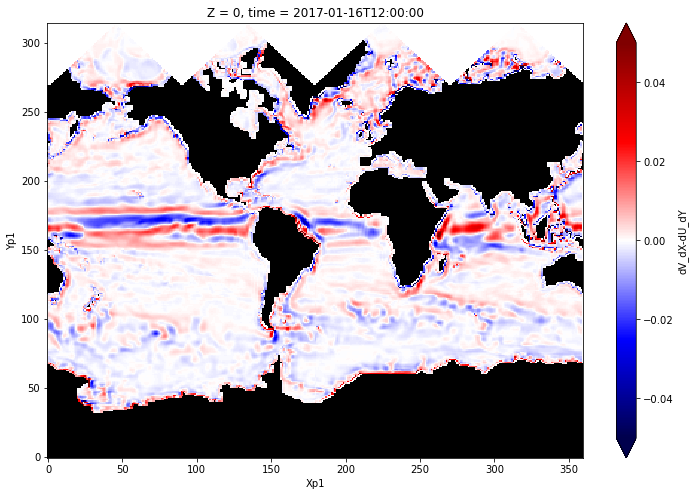

In [40]:
cut_od._ds['DepthG'].plot(cmap='Greys_r',vmin=0, vmax=1, add_colorbar=False)
(1e4*cut_od._ds['dV_dX-dU_dY'].isel(Z=0).where(cut_od._ds['DepthG'] > 0)).plot(cmap='seismic', vmin=-0.05, vmax=0.05)
plt.savefig('Figures/LLC90_SurfaceVorticity_all_faces.png')
plt.show()